In [1]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from time import time

# plotting utilities
import revert.plot as rp

# infusion data loaders
from revert import infusion

### Read ICP recording and timestamps

In [2]:
from revert.transforms import filter_spikes, bandpass, Troughs

db = infusion.Dataset("full")
fs = 100
file = db.get(33)

# read full icp recording
icp_raw = file.icp()

# interpolate on missing data points
icp_full, mask = filter_spikes(icp_raw)

# read timestamps from $INFUSION_DATASETS/periods-full.json
periods = db.periods[file.key]

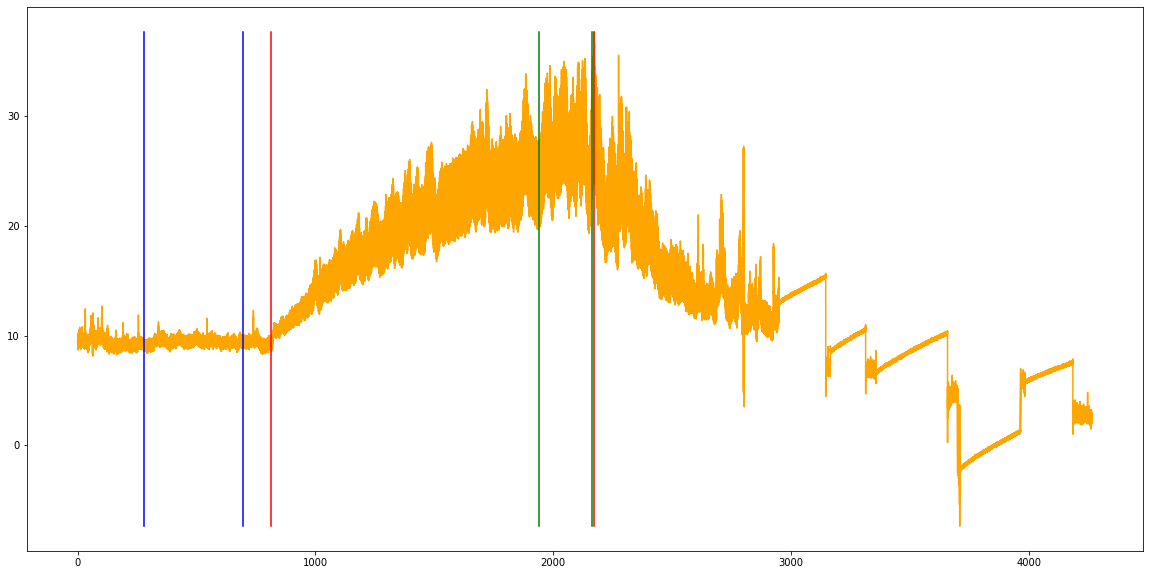

inf_20180305121332_Allister_GARNHAM: 1 block(s)


In [3]:
# plot with timestamps
rp.infusion(icp_full, periods)
plt.show()
print(f'{file.key}: {file.nblocks()} block(s)')

### Segment baseline signal

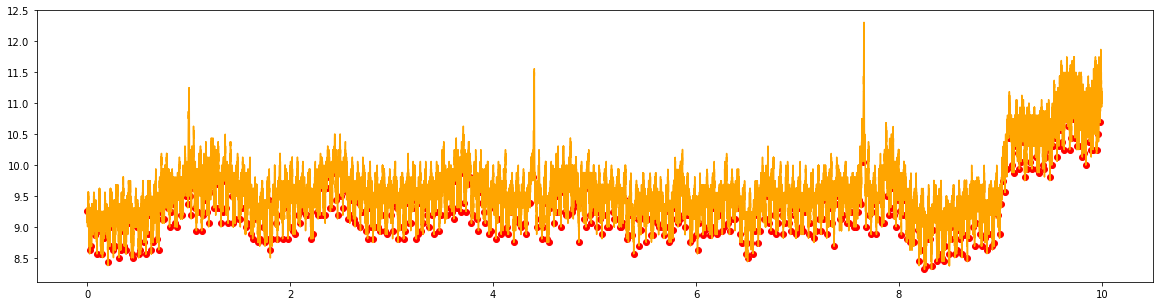

In [4]:
# Baseline first minutes
i0     = periods["start"]
i1, i2 = periods["Baseline"]
N = 10 * 6000
time = torch.arange(N) / (fs * 60)
icp  = icp_full[int(100 * (i1 - i0)):int(100 * (i1 - i0)) + N]

# Find diastoles
argmin  = Troughs(N, 50)
bp      = bandpass(0.6, 12, fs)
troughs = argmin(bp(icp))

# Plot 
plt.figure(figsize=(20, 5))
plt.plot(time, icp, color='orange')
plt.scatter(time[troughs], icp[troughs], color='red')
plt.show()

In [5]:
db.filter(lambda f: db.periods[f.key]["Baseline"])
list(db.periods.keys())

['INF_20080109140252_INF1',
 'inf_20140905145909_INF2',
 'INF_20171020151801_INF1',
 'inf_20111121115010_INF2',
 'inf_20170116114727_INF2',
 'INF_20050512142515_INF1',
 'INF_20181025114511_INF2',
 'INF_20131029160336_INF1',
 'Inf_20181112125552_INF1',
 'INF_20171019091020_INF1',
 'inf_20171004115132_INF2',
 'inf_20111128125427_INF2',
 'INF_20130117145951_INF1',
 'inf_20120118123309_INF2',
 'INF_20190731104743_INF2',
 'INF_20041119184116_INF1',
 'inf_20180305121332_Allister_GARNHAM',
 'INF_20140829132717_INF1',
 'INF_20051012120451_INF1',
 'INF_20191122114849_INF2',
 'inf_20160414154225_INF2',
 'inf_20100616161327_INF1',
 'INF_20041026143441_INF1',
 'INF_20081210100612_INF1',
 'INF_20080609131512_INF1',
 'INF_20190626133243_INF2',
 'INF_20050729164642_INF1',
 'inf_20180424165402_Ball_Delcie',
 'INF_20100805134909_INF1',
 'inf_20180122113114_Laura_REEVE',
 'inf_20180227161715_Nadine_LENNOX',
 'INF_20050818141612_INF1',
 'inf_20140721123111_INF2',
 'INF_20191118104801_INF2',
 'INF_2013010

### Model image of the segments


In [6]:
from models   import ConvNet
from infusion import segment, mask_center, diff

# model trained on synthetic augmentations only
# (noise, scalings, dc shifts) - see revert/experiments/twins.py
model = ConvNet.load("pretrained.pt")

# centered segments
pulses, mask = segment(bp(icp), troughs, 128, before=0)
x, x_mean, x_slope = mask_center(pulses, mask, output='slopes')

# model output
with torch.no_grad():
    y  = model(x).detach()

In [7]:
# model variation
dy = diff(y.T).T
y_m = y - y.mean([0])[None,:]

# energy
q1, q2 = y_m.norm(dim=[1]), dy.norm(dim=[1])
q = q1 + q2

# temperature
T = 1.5

# Gibbs density (~ softmin)
p = torch.exp(- q / T)
p /= p.sum()

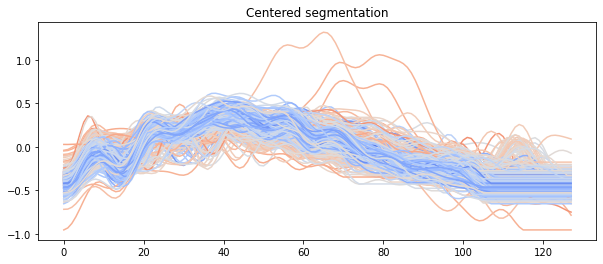

In [8]:
p_norm = (p - p.min()) / (p.max() - p.min())
color=cm.coolwarm_r(p_norm)

plt.figure(figsize=(10, 4))
for xi, ci in zip(x, color):
    plt.plot(xi, color=ci)
plt.title("Centered segmentation")
plt.show()

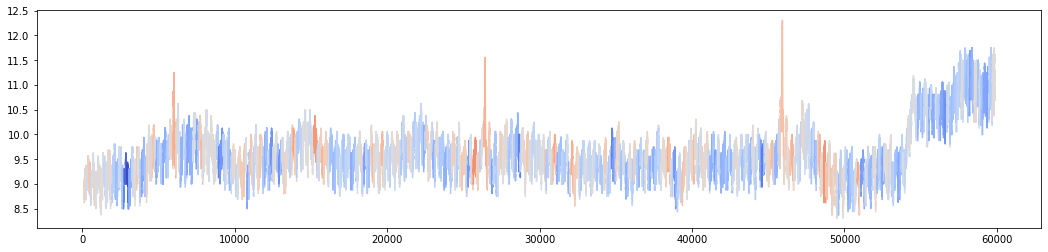

In [9]:
plt.figure(figsize=(18, 4))
for i, j, cij in zip(troughs[:-1], troughs[1:], color):
    ij = i + torch.arange(j - i)
    pij = icp[i:j]
    plt.plot(ij, pij, color=cij)

### Pulse selection

Text(0.5, 1.0, 'Max probability pulses')

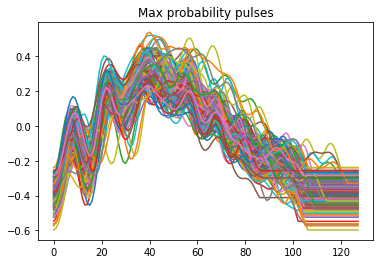

In [10]:
idx = p.sort(descending=True).indices[:128]

plt.plot(x[idx].T)
plt.title("Max probability pulses")

---
## Segmentation results

Read from results of `revert/scripts-infusion/extract_pulses.py`

In [12]:
d = torch.load("../scripts-infusion/baseline.pt")
x = d['pulses']

Text(0.5, 1.0, 'INF_20080109140252_INF1')

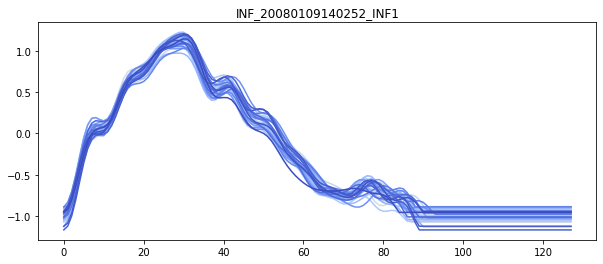

In [20]:
i = 3
rp.pulses(x[i][:32], c=torch.linspace(.5, 1, 32))
rp.plt.title(f"{d['keys'][0]}")